# Convolutional Gaussian Processes
Mark van der Wilk (July 2019)

Here we show a simple example of the rectangles experiment, where we compare a normal SE GP, and a convolutional GP. This is similar to the experiment in [1].

[1] Van der Wilk, Rasmussen, Hensman (2017). Convolutional Gaussian Processes. *Advances in Neural Information Processing Systems 30*.

## Generate dataset
Generate a simple dataset of rectangles. We want to classify whether they are tall or wide. Note that here we take some care to make sure that the rectangles don't touch the edge, which is different to the original paper. We do this to avoid needing to use patch weights, which are needed to correctly account for edge effects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

In [2]:
def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0:x1+1] = 1
    
def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1
    
def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return d.reshape(num, w * h), Y

In [3]:
X, Y = make_rectangles_dataset(100, 28, 28)
Xt, Yt = make_rectangles_dataset(300, 28, 28)

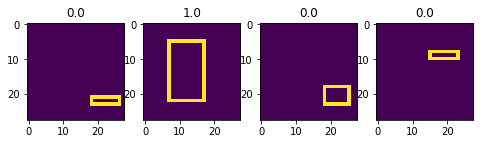

In [4]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(28, 28))
    plt.title(Y[i, 0])

## Squared Exponential kernel

In [5]:
rbf_m = gpflow.models.SVGP(X, Y, gpflow.kernels.SquaredExponential(X.shape[1]), gpflow.likelihoods.Bernoulli(),
                           feat=gpflow.features.InducingPoints(X.copy()))
rbf_m.feature.trainable = False
sci_opt = gpflow.train.ScipyOptimizer()
sci_opt.minimize(rbf_m)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 66.611693
  Number of iterations: 46
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 66.611693
  Number of iterations: 46
  Number of functions evaluations: 59


In [6]:
train_err = np.mean((rbf_m.predict_y(X)[0] > 0.5).astype('float') == Y)
test_err = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).astype('float') == Yt)

In [7]:
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")

Train acc: 100.0%
Test acc : 63.66666666666667%


## Convolutional kernel

In [8]:
with gpflow.defer_build():
    conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(9), [28, 28], [3, 3])
    conv_k.basekern.variance.transform = gpflow.transforms.Logistic(0, 100)
conv_k.compile()
conv_f = gpflow.features.InducingPatch(np.unique(conv_k.compute_patches(X).reshape(-1, 9), axis=0))
conv_m = gpflow.models.SVGP(X, Y, conv_k, gpflow.likelihoods.Bernoulli(), feat=conv_f)

In [9]:
conv_m.feature.trainable = False
conv_m.kern.basekern.variance.trainable = False
sci_opt.minimize(conv_m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.699154
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.699154
  Number of iterations: 36
  Number of functions evaluations: 41


In [10]:
conv_m.kern.basekern.variance.trainable = True
sci_opt.minimize(conv_m, maxiter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 41.429404
  Number of iterations: 166
  Number of functions evaluations: 187


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 41.429404
  Number of iterations: 166
  Number of functions evaluations: 187
/home/mark/projects/GPflow/gpflow/transforms.py:222: RuntimeWarning: divide by zero encountered in log
  return -np.log((self.b - self.a) / (y - self.a) - 1.)


In [11]:
train_err = np.mean((conv_m.predict_y(X)[0] > 0.5).astype('float') == Y)
test_err = np.mean((conv_m.predict_y(Xt)[0] > 0.5).astype('float') == Yt)

In [12]:
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")

Train acc: 99.0%
Test acc : 98.33333333333333%


In [13]:
rbf_m

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(100, 784)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,4.306424783151995
SVGP/kern/variance,Parameter,None,+ve,True,(),True,2.668608782474334
SVGP/q_mu,Parameter,None,(none),True,"(100, 1)",True,"[[-0.667105658903033], [0.8821046827731007], [..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 100, 100)",True,"[[[0.6016413169797602, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [14]:
conv_m

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(45, 9)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
SVGP/kern/basekern/lengthscales,Parameter,None,+ve,True,(),True,0.5736330807912707
SVGP/kern/basekern/variance,Parameter,None,"[0.0, 100.0]",True,(),True,100.0
SVGP/q_mu,Parameter,None,(none),True,"(45, 1)",True,"[[0.006146927825698526], [0.002225992430651592..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 45, 45)",True,"[[[-0.026950949804429, 0.0, 0.0, 0.0, 0.0, 0.0..."


## Conclusion
The convolutional kernel performs much better in this simple task. It demonstrates non-local generalisation of the strong assumptions in the kernel.